## outline & summary

- q-learning => DQN（Deep Q Learning network)
- q_learning base q-table
    - state 需要是/处理成离散的（discrete）
    - q-table：行是state，列是action；
    - $Q(s,a)$：动作价值（value），不是概率分布；
        - $Q(s_t,a_t)$是在时刻 $t$，状态 $s_t$下采取动作 $a_t$ 时获得的折扣奖励总和（discounted total reward）
            - 未来的价值折现到现在；
    - image（pixels） as a state，状态变量的数量非常之大；
- dqn：nn(state) => action value，
    - q table => q function（**拟合/回归**，state vector 与 action value 的关系） 
    - 输入输出：
        - 输入（input）：state vector;
            - cartpole：4d vector（位置，速度，角度，和角速度），甚至都需要care其semantic meaning；
        - 输出：action space value，$Q(s_t,a_t)$
            - shape：action space size；
            - CartPole：2d（left/right）

## DQN

$$
\begin{split}
&Q(s_t,a_t) = Q(s_t,a_t) + \eta\cdot (R_{t+1}+\gamma \max_a Q(s_{t+1},a)-Q(s_t,a_t))\\
&Q(s_t,a_t) = R_{t+1}+\gamma\cdot \max_aQ(s_{t+1},a)
\end{split}
$$

- iteration algorithm
- temporal difference error（TD）: $R_{t+1}+\gamma\cdot \max_aQ(s_t,a) - Q(s_t,a_t)$
- learning objective：
    - MES（square loss）: $E(s_t,a_t)=\left(R_{t+1}+\gamma\max_aQ(s_{t+1},a)-Q(s_t,a_t)\right)^2$

### 几个核心技术

- experience replay（经验回放）
    - 不像 q-table 的 q-learning，每一步都学习（update）该步的内容（experience）
        - 对于 q-table 而言，每一步（step）都学习该步的内容，神经网络连续地学习时间上相关性高的内容（事实上，时间 $t$ 的学习内容，和时间 $t+1$ 的学习内容非常相似，这样的话，收敛就会很慢；
    - 而是将每一步（step）的内容存储在经验池（experience pool）并随机从经验池中提取内容（replay，回放）让NN学习；
        - 也是一种批次化（batch），使用经验池中的多个步骤的经验；

- loss function 使用 huber 而不是 square loss
    - 误差很大时（$|\delta|>1$），平方误差会导致误差函数的输出过大，导致学习难以稳定

$$
\mathcal L(\delta)=\begin{cases}
\frac12\delta^2,  &\quad |\delta|\leq 1,\\
|\delta|-\frac12, &\quad |\delta|\gt 1
\end{cases}
$$

In [5]:
from IPython.display import Image

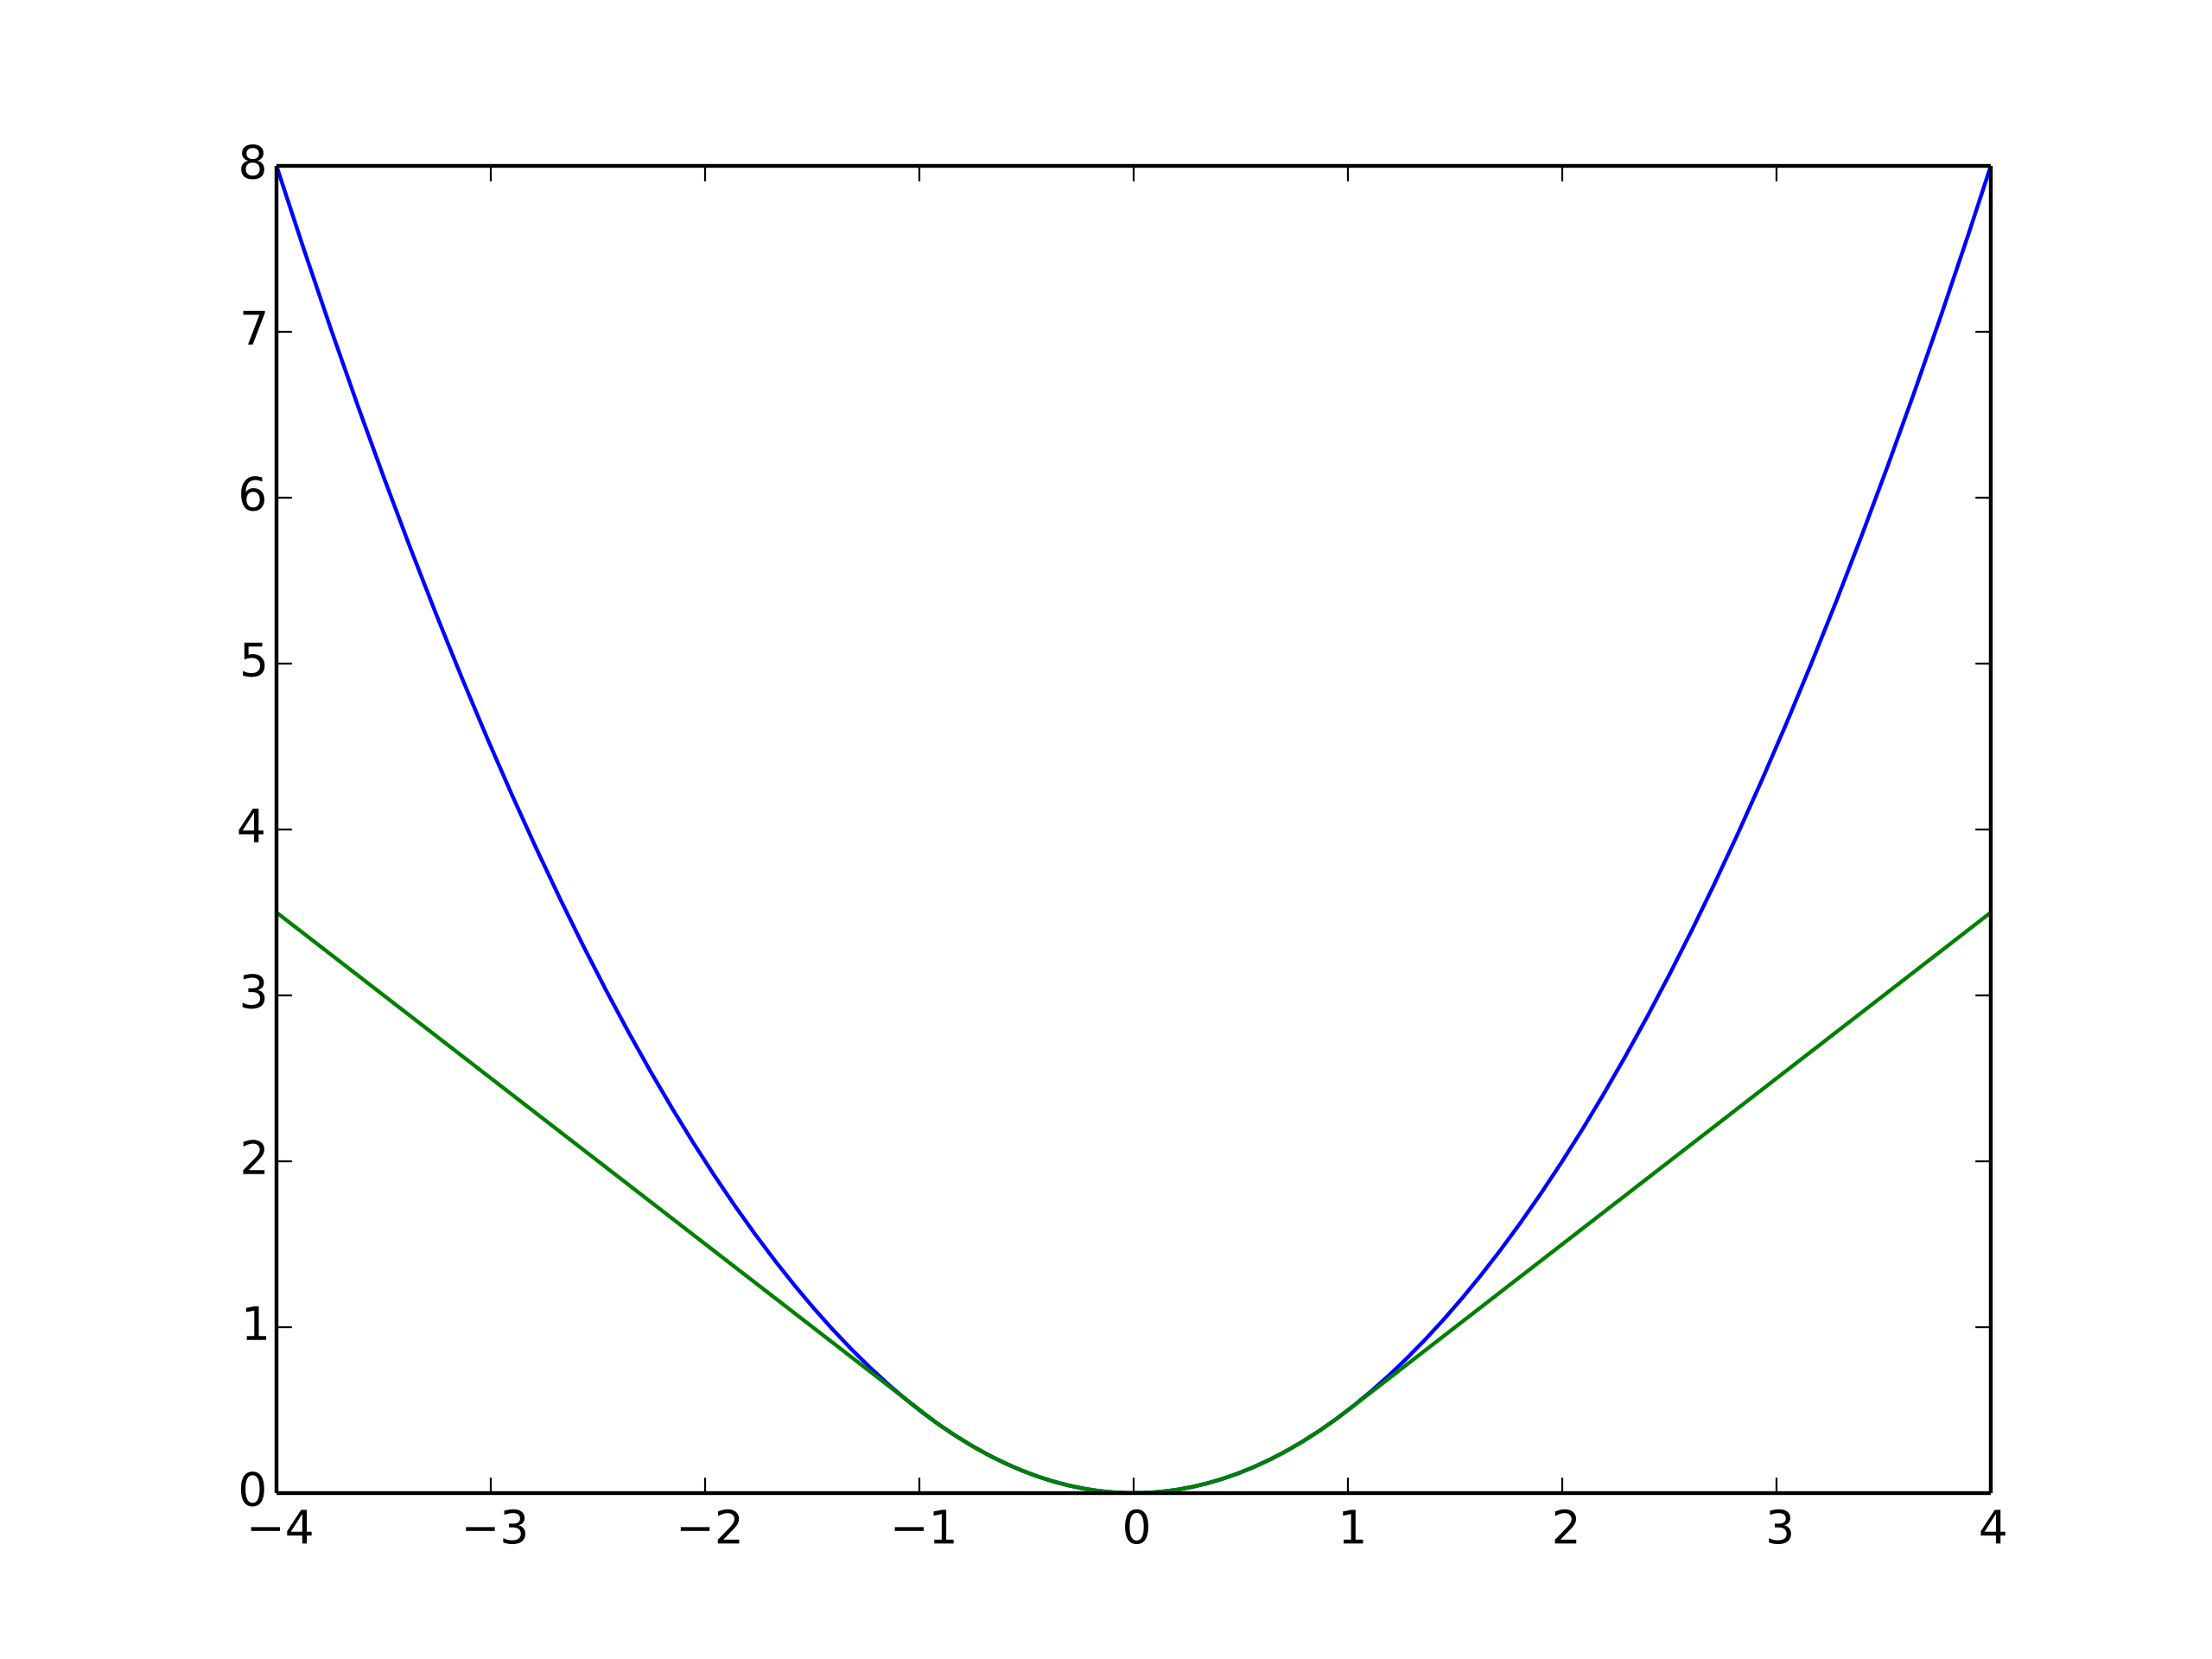

In [9]:
Image('./imgs/Huber_loss.svg.png', width=600, height=450)

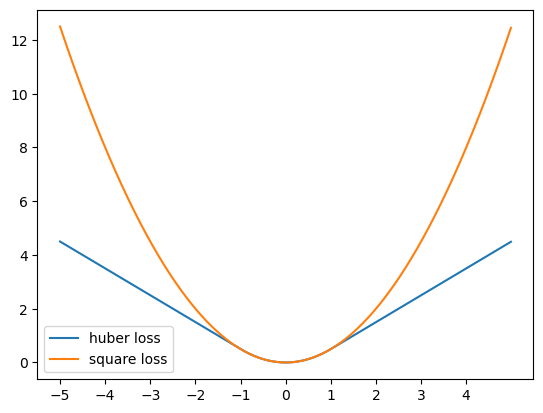

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def huber_loss(delta, beta=1):
    if np.abs(delta) <= beta:
        return 0.5*delta**2/beta
    return abs(delta) - 0.5*beta

def square_loss(delta):
    return 0.5*delta**2

deltas = np.arange(-5, 5, 0.01)
plt.plot(deltas, [huber_loss(delta) for delta in deltas])
plt.plot(deltas, square_loss(deltas))
plt.xticks(np.arange(-5, 5, step=1))
plt.legend(['huber loss', 'square loss'])

## DQN 实现

### experience replay

- 构造批次化训练数据
- 让整个训练过程更加稳定

In [1]:
from collections import namedtuple
import random

In [6]:
# s_t, a_t => s_{t+1}
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [27]:
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.index = 0
        
    def push(self, state, action, next_state, reward):
        if len(self.memory) < self.capacity:
            # placeholder
            self.memory.append(None)
        self.memory[self.index] = Transition(state, action, next_state, reward)
        self.index = (self.index + 1) % self.capacity
        
    # list of transition
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

### DQN network

In [39]:
from torch import nn
import torch
import torch.nn.functional as F
from torch import optim

In [42]:
# Q_function base NN
class DQN(nn.Module):
    def __init__(self, n_states, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_states, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)
    def forward(self, x):
        # x.shape: batch_size*n_states
        # output.shape: batch_size*n_actions, state_action_value
        return self.fc3(F.relu(self.fc2(F.relu(self.fc1(x)))))

### Agent

- 计算过程中 tensor shape 的变化以及 shape的对齐

In [17]:
trs = [Transition(1, 2, 3, 4), Transition(5, 6, 7, 8)]
trs = Transition(*zip(*trs))
trs

Transition(state=(1, 5), action=(2, 6), next_state=(3, 7), reward=(4, 8))

In [22]:
t = torch.rand(3, 2)
print(t)
print(t.max(dim=1)[0])
t.max(dim=1)[1]

tensor([[0.6664, 0.1629],
        [0.9828, 0.9913],
        [0.1747, 0.1865]])
tensor([0.6664, 0.9913, 0.1865])


tensor([0, 1, 1])

In [25]:
torch.IntTensor([[random.randrange(2)]]).shape

torch.Size([1, 1])

In [51]:
class Agent:
    def __init__(self, n_states, n_actions, eta=0.5, gamma=0.99, capacity=10000, batch_size=32):
        self.n_states = n_states
        self.n_actions = n_actions
        self.eta = eta
        self.gamma = gamma
        self.batch_size = batch_size
        
        self.memory = ReplayMemory(capacity)
        self.model = DQN(n_states, n_actions)
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
    
    def _replay(self):
        if len(self.memory) < self.batch_size:
            return
        # list of transition
        batch = self.memory.sample(self.batch_size)
        # Transition, column: len(tuple) == batch_size
        batch = Transition(*zip(*batch))
        
        # s_t.shape: batch_size * 4
        state_batch = torch.cat(batch.state)
        # a_t.shape: batch_size * 1
        action_batch = torch.cat(batch.action)
        # r_{t+1}.shape: batch_size * 1
        reward_batch = torch.cat(batch.reward)
        # < batch_size
        non_final_next_state_batch = torch.cat([s for s in batch.next_state if s is not None])
        
    
        # 构造模型训练用的输入和输出（true）
        # s_t, input
        
        # pred: Q(s_t, a_t)
        # true: R_{t+1} + \gamma*\max_aQ(s_t, a)
        
        # 开启 eval 模式
        self.model.eval()
        
        # pred, batch_size*1
        state_action_values = self.model(state_batch).gather(dim=1, index=action_batch)
        
        # true: R_{t+1} + \gamma*\max_aQ(s_t, a)
        # tuple(map(lambda s: s is not None, batch.next_state)): batch_size 长度的 0/1
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))
        next_state_values = torch.zeros(self.batch_size)
        # Q(s_{t+1}, a)
        next_state_values[non_final_mask] = self.model(non_final_next_state_batch).max(dim=1)[0].detach()
        
        # (batch_size, )
        expected_state_action_values = reward_batch + self.gamma * next_state_values
        
        
        # 开启train mode
        self.model.train()
        
        # expected_state_action_values.unsqueeze(1): (batch_size, ) => (batch_size, 1)
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def update_q_function(self):
        self._replay()
        
    def memorize(self, state, action, next_state, reward):
        self.memory.push(state, action, next_state, reward)
    
    # action policy
    # epsilon_greedy
    # double e: explore, exploit
    def choose_action(self, state, episode):
        eps = 0.5*1/(1+episode)
        if random.random() < eps:
            # explore
            action = torch.IntTensor([[random.randrange(self.n_actions)]])
        else:
            self.model.eval()
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1, 1)
        return action

### agent 与 env 进行交互

In [29]:
import gym
gym.__version__

'0.15.4'

In [30]:
!pip install pyglet==1.2.4

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/


In [31]:
env = gym.make('CartPole-v0')

In [35]:
print(env.observation_space.shape[0])
print(env.action_space.n)

4
2


In [36]:
env.reset()

array([-0.03329124, -0.02317109,  0.00609648, -0.04172689])

In [53]:
from JSAnimation.IPython_display import display_animation
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib import animation

In [54]:
def display_frames_as_gif(frames, output):
    """
    Displays a list of frames as a gif, with controls
    以gif格式显示关键帧列，带有控件
    """
    
    fig = plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0),dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        img = patch.set_data(frames[i])
        return img   ## *** return是必须要有的 ***
        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    
    anim.save(output)
    return HTML(anim.to_jshtml())  ## *** 返回一个HTML对象，以便被调用者显示。 ***
    # display(display_animation(anim, default_mode='loop'))

In [55]:
env = gym.make('CartPole-v0')
n_states = env.observation_space.shape[0]
n_actions = env.action_space.n

max_episodes = 500
max_steps = 200

complete_episodes = 0
finished_flag = False

agent = Agent(n_states, n_actions)
frames = []

for episode in range(max_episodes):
    state = env.reset()
    state = torch.from_numpy(state).type(torch.FloatTensor).unsqueeze(0)
    for step in range(max_steps):
        if finished_flag == True:
             frames.append(env.render(mode='rgb_array'))
        # IntTensor of 1*1
        action = agent.choose_action(state, episode)
        
        # transition on env
        next_state, _, done, _ = env.step(action.item())
        
        if done:
            next_state = None
            
            if step < 195:
                # 1d
                reward = torch.FloatTensor([-1.])
                complete_episodes = 0
            else:
                reward =  torch.FloatTensor([1.])
                complete_episodes += 1
        else:
            reward = torch.FloatTensor([0])
            # (4, )
            next_state = torch.from_numpy(next_state).type(torch.FloatTensor)
            # (4, ) ==> (1, 4)，便于后续的 torch.cat => (1, 4) => (32, 4)
            next_state = next_state.unsqueeze(0)
        agent.memorize(state, action, next_state, reward)
        agent.update_q_function()
        state = next_state
        
        if done:
            print(f'episode: {episode}, steps: {step}')
            break
    if finished_flag == True:
        break
        
    if complete_episodes >= 10:
        finished_flag = True
        print('连续成功10轮')
        

episode: 0, steps: 11
episode: 1, steps: 10
episode: 2, steps: 10
episode: 3, steps: 8
episode: 4, steps: 11
episode: 5, steps: 8
episode: 6, steps: 8
episode: 7, steps: 12
episode: 8, steps: 15
episode: 9, steps: 11
episode: 10, steps: 8
episode: 11, steps: 9


/var/folders/1j/fv7y5kz53592pt9xx4tqfrl80000gn/T/ipykernel_29531/153055639.py:49: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525473998/work/aten/src/ATen/native/IndexingUtils.h:28.)
  next_state_values[non_final_mask] = self.model(non_final_next_state_batch).max(dim=1)[0].detach()


episode: 12, steps: 10
episode: 13, steps: 9
episode: 14, steps: 15
episode: 15, steps: 34
episode: 16, steps: 16
episode: 17, steps: 19
episode: 18, steps: 29
episode: 19, steps: 17
episode: 20, steps: 12
episode: 21, steps: 13
episode: 22, steps: 33
episode: 23, steps: 24
episode: 24, steps: 51
episode: 25, steps: 98
episode: 26, steps: 64
episode: 27, steps: 57
episode: 28, steps: 128
episode: 29, steps: 93
episode: 30, steps: 83
episode: 31, steps: 119
episode: 32, steps: 136
episode: 33, steps: 199
episode: 34, steps: 199
episode: 35, steps: 121
episode: 36, steps: 199
episode: 37, steps: 199
episode: 38, steps: 199
episode: 39, steps: 199
episode: 40, steps: 199
episode: 41, steps: 199
episode: 42, steps: 199
episode: 43, steps: 199
episode: 44, steps: 199
episode: 45, steps: 199
连续成功10轮
episode: 46, steps: 199


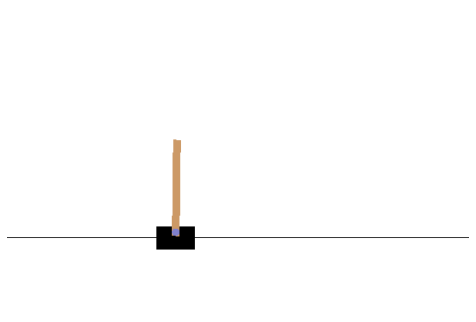

In [56]:
display_frames_as_gif(frames, 'save/dqn_cartpole.gif')